In [1]:
import tensorflow
from keras.utils.generic_utils import serialize_keras_object
from tensorflow.keras.layers import LeakyReLU

from tensorflow.keras.layers import InputLayer
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import json
import numpy as np
import pandas as pd

Using TensorFlow backend.


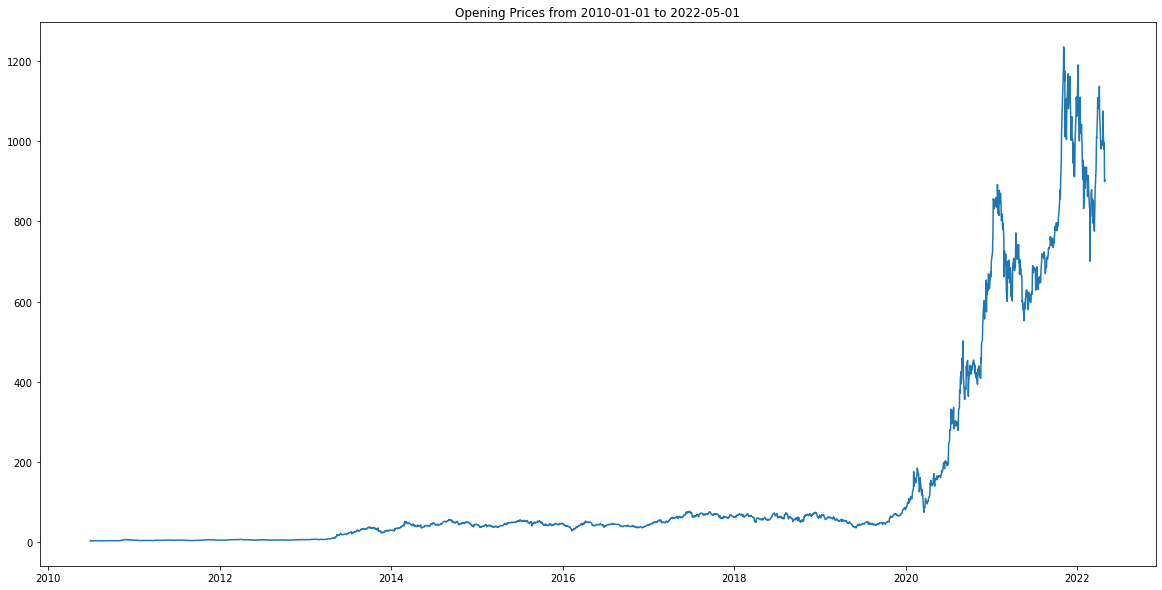

In [2]:
# import modules
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
  
# initializing Parameters
start = "2010-01-01"
end = "2022-05-01"
symbols = ["TSLA"]
  
# Getting the data
dataOrg = pdr.get_data_yahoo(symbols, start, end)
  
# Display
plt.figure(figsize = (20,10))
plt.title('Opening Prices from {} to {}'.format(start, end))
plt.plot(dataOrg['Open'])
plt.show()

In [3]:
data = dataOrg.droplevel(level=1,axis=1)
data

Attributes,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2010-06-29,4.778000,4.778000,5.000000,3.508000,3.800000,93831500.0
2010-06-30,4.766000,4.766000,6.084000,4.660000,5.158000,85935500.0
2010-07-01,4.392000,4.392000,5.184000,4.054000,5.000000,41094000.0
2010-07-02,3.840000,3.840000,4.620000,3.742000,4.600000,25699000.0
2010-07-06,3.222000,3.222000,4.000000,3.166000,4.000000,34334500.0
...,...,...,...,...,...,...
2022-04-25,998.020020,998.020020,1008.619995,975.299988,978.969971,22780400.0
2022-04-26,876.419983,876.419983,1000.000000,875.000000,995.429993,45377900.0
2022-04-27,881.510010,881.510010,918.000000,877.359985,898.580017,25652100.0


In [4]:
df = data[["Open", "High", "Low", "Adj Close", "Volume"]].pct_change().dropna()

df.head()

Attributes,Open,High,Low,Adj Close,Volume
Date,,,,,
2010-06-30,0.357368,0.216800,0.328392,-0.002512,-0.084151
2010-07-01,-0.030632,-0.147929,-0.130043,-0.078472,-0.521804
2010-07-02,-0.080000,-0.108796,-0.076961,-0.125683,-0.374629
2010-07-06,-0.130435,-0.134199,-0.153928,-0.160938,0.336025
2010-07-07,-0.180000,-0.168500,-0.053695,-0.019243,0.007980


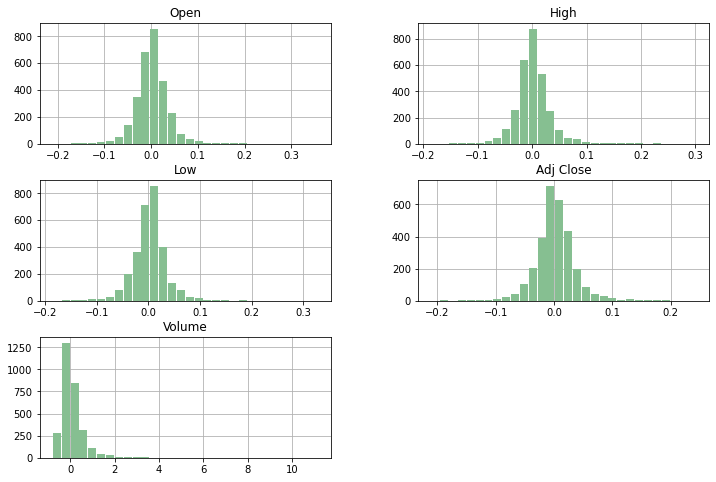

In [5]:
hist = df.hist(bins=30,figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

In [6]:
df2 = df.copy(deep=True)
df2[["OriginalVolume"]] = data[["Volume"]]

df2.head()

Attributes,Open,High,Low,Adj Close,Volume,OriginalVolume
Date,,,,,,
2010-06-30,0.357368,0.216800,0.328392,-0.002512,-0.084151,85935500.0
2010-07-01,-0.030632,-0.147929,-0.130043,-0.078472,-0.521804,41094000.0
2010-07-02,-0.080000,-0.108796,-0.076961,-0.125683,-0.374629,25699000.0
2010-07-06,-0.130435,-0.134199,-0.153928,-0.160938,0.336025,34334500.0
2010-07-07,-0.180000,-0.168500,-0.053695,-0.019243,0.007980,34608500.0


In [7]:
indexes = df[((df.Volume == float("inf")))].index
for i in indexes:
    df.at[i, "Volume"] = max(df.Volume.drop(indexes))

In [8]:
n_steps = 30
features = []
labels = []
for i in range(len(df)-n_steps):
    input_data = df.iloc[i:i+n_steps].values
    features.append(input_data)
    if df['Adj Close'].iloc[i+n_steps] >= 0:
        # UP
        label = 1
        
    else:
        # DOWN
        label = 0
    labels.append(label)

In [9]:
features = np.array(features)
labels = np.array(labels)

In [10]:
# use second part of data for training instead
test_length = int(len(features) * 0.3)
X_train = features[test_length:]
X_test = features[:test_length]
y_train = labels[test_length:]
y_test = labels[:test_length]

In [11]:
display(np.mean(y_train))
display(np.mean(y_test))

0.5176755447941889

0.5310734463276836

In [12]:
X_train[0].shape

(30, 5)

In [42]:
# model = Sequential([Dense(256, input_shape=X_train[0].shape, activation='relu'),
#                     Dense(512, activation='relu'),
#                     Flatten(),
#                     #Dense(256, activation='relu'),
#                     Dense(1, activation='sigmoid')
#                    ])


from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

# Import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


# Initialising the RNN
model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train[0].shape)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# # Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# # Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))


# Adding the output layer
model.add(Dense(units = 1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'mse'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 30, 50)            11200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 30, 50)            20200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 30, 50)            20200     
_________________________________________________________________
dropout_9 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)               

In [43]:
%%time

history = model.fit(x=X_train, y=y_train, validation_data=(X_test,y_test), epochs=20)

Train on 2065 samples, validate on 885 samples
Epoch 1/20
2065/2065 [==============================] - 24s 12ms/step - loss: 0.6943 - accuracy: 0.5036 - mse: 0.2506 - val_loss: 0.6943 - val_accuracy: 0.4689 - val_mse: 0.2506
Epoch 2/20
2065/2065 [==============================] - 20s 10ms/step - loss: 0.6932 - accuracy: 0.5056 - mse: 0.2500 - val_loss: 0.6920 - val_accuracy: 0.5311 - val_mse: 0.2494
Epoch 3/20
2065/2065 [==============================] - 20s 9ms/step - loss: 0.6927 - accuracy: 0.5157 - mse: 0.2498 - val_loss: 0.6928 - val_accuracy: 0.5311 - val_mse: 0.2498
Epoch 4/20
2065/2065 [==============================] - 29s 14ms/step - loss: 0.6927 - accuracy: 0.5167 - mse: 0.2498 - val_loss: 0.6919 - val_accuracy: 0.5311 - val_mse: 0.2494
Epoch 5/20
2065/2065 [==============================] - 42s 21ms/step - loss: 0.6932 - accuracy: 0.5167 - mse: 0.2500 - val_loss: 0.6918 - val_accuracy: 0.5311 - val_mse: 0.2493
Epoch 6/20
2065/2065 [==============================] - 50s 24ms

In [44]:
print(history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'val_mse', 'loss', 'accuracy', 'mse'])


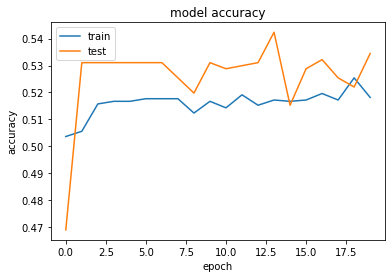

In [45]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
scores = model.evaluate(X_train, y_train, verbose=10)
print('Accuracy on training data: {}%  Error on training data: {}'.format(scores[1], 1 - scores[1]))

pred_test= model.predict(X_test)
scores2 = model.evaluate(X_test, y_test, verbose=10)
print('Accuracy on test data: {}%  Error on test data: {}'.format(scores2[1], 1 - scores2[1]))

Accuracy on training data: 0.527845025062561%  Error on training data: 0.47215497493743896
Accuracy on test data: 0.501694917678833%  Error on test data: 0.498305082321167


In [46]:
display(X_test.shape)
y_hat = model.predict(X_test)
display(y_hat.shape)

(885, 30, 5)

(885, 1)

In [52]:
results = pd.DataFrame({'y': y_test.flatten(), 'y_hat': y_hat.flatten()})
results_filer = results[results["y_hat"] > 0.5]
results_filer

,y,y_hat
0,0,0.521317
1,1,0.515771
2,1,0.514484
3,1,0.512413
4,0,0.509220
...,...,...
880,1,0.509465
881,0,0.512641
882,1,0.516246
883,0,0.519891


In [53]:
#In the dataframe "results_filer" above, it only includes the prediction of moving upward. Therefore, the mean of
# y is equivalent to the accuracy of model

np.mean(results_filer["y"])

0.5339578454332553

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)